## Synthetic data generation

In [106]:
import random
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from math import tanh

In [93]:
seed = 6549
random.seed(seed)

d = 2
n = 100

x_mat = [[0,0] for i in range(n)]
y_vec = [0 for i in range(n)]

separable = 1 # Set to 1 for separable data
n_wrong = 5 # In the non-separable case, this is the number of points whose labels are changed

In [94]:
theta = [1, -1]
theta0 = 0.1

for t in range(n):
    x = [random.gauss(0,1), random.gauss(0,1)]
    val = sum([a*b for a,b in zip(x, theta)]) + theta0
    while abs(tanh(val)) < random.uniform(0.3,0.5):
        x = [random.uniform(0,1), random.uniform(0,1)]
        val = sum([a*b for a,b in zip(x, theta)]) + theta0
    if val > 0:
        y = 1
    else:
        y = -1
        
    x_mat[t] = x
    y_vec[t] = y
    
if separable == 0:
    for t in range(n_wrong):
        y_vec[t] = -y_vec[t]

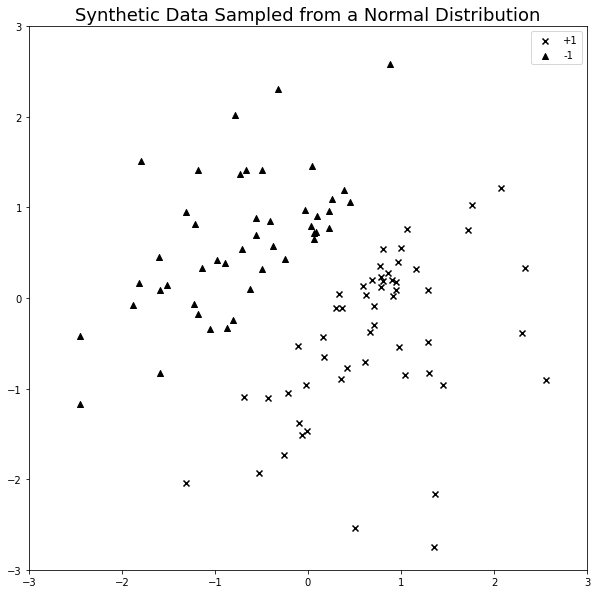

In [95]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.title("Synthetic Data Sampled from a Normal Distribution", fontsize = 18)
for t, point in enumerate(x_mat):
    if y_vec[t] == 1: 
        plt.scatter(point[0],point[1], color = "k", marker = "x", label = "+1" if y_vec.index(1) == t else "")
    elif y_vec[t] == -1:
        plt.scatter(point[0],point[1], color = "k", marker = "^", label = "-1" if y_vec.index(-1) == t else "")
ax.legend(loc = "upper right")

In [96]:
x_train, x_test, y_train, y_test = train_test_split(x_mat, y_vec, test_size = 0.95, random_state = seed)

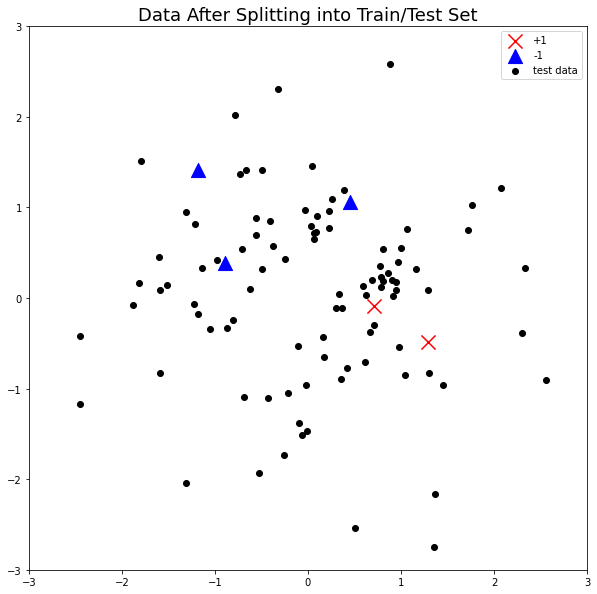

In [97]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.title("Data After Splitting into Train/Test Set", fontsize = 18)
for t, point in enumerate(x_train):
    if y_train[t] == 1: 
        plt.scatter(point[0],point[1], color = "r", marker = "x", s = 200, label = "+1" if y_train.index(1) == t else "")
    elif y_train[t] == -1:
        plt.scatter(point[0],point[1], color = "b", marker = "^", s = 200, label = "-1" if y_train.index(-1) == t else "")
for t, point in enumerate(x_test):
    plt.scatter(point[0],point[1], color = "k", marker = "o", label = "test data" if x_test.index(point) == 0 else "")
ax.legend(loc = "upper right")

## Naive SVM

In [118]:
C = 10
C_star = 10
num_pos = 50

In [119]:
clf = svm.LinearSVC(C=C, penalty = 'l2', loss = 'hinge', max_iter = 1000, random_state = seed)
clf.fit(x_train, y_train)

LinearSVC(C=10, loss='hinge', random_state=6549)

In [120]:
y_naive_pred = list(clf.predict(x_test))

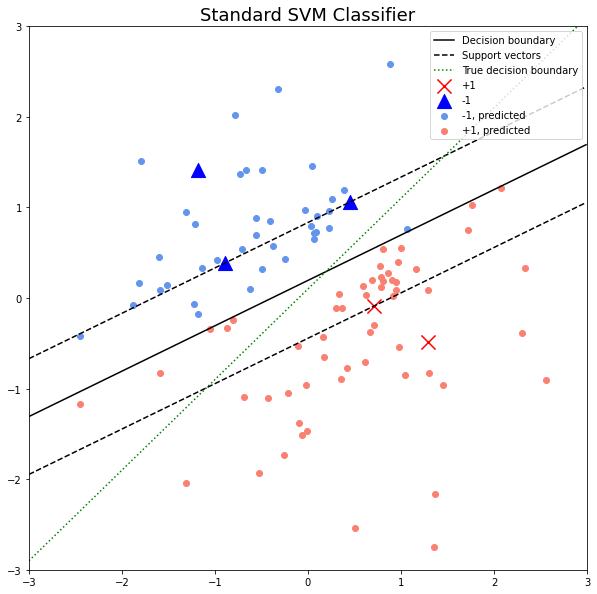

In [121]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.title("Standard SVM Classifier", fontsize = 18)
for t, point in enumerate(x_train):
    if y_train[t] == 1: 
        plt.scatter(point[0],point[1], color = "r", marker = "x", s=200, label = "+1" if y_train.index(1) == t else "")
    elif y_train[t] == -1:
        plt.scatter(point[0],point[1], color = "b", marker = "^", s=200, label = "-1" if y_train.index(-1) == t else "")
for t, point in enumerate(x_test):
    if y_naive_pred[t] == 1:
        plt.scatter(point[0],point[1], color = "salmon", marker = "o", label = "+1, predicted" if y_naive_pred.index(1) == t else "")
    elif y_naive_pred[t] == -1:
        plt.scatter(point[0],point[1], color = "cornflowerblue", marker = "o", label = "-1, predicted" if y_naive_pred.index(-1) == t else "")

theta_hat = list(clf.coef_[0])
theta0_hat = clf.intercept_[0]
x1s = [i/100 for i in range(-300,300)]
y1s = [-(x1*theta_hat[0]+theta0_hat)/theta_hat[1] for x1 in x1s]
y2s = [(1-x1*theta_hat[0]-theta0_hat)/theta_hat[1] for x1 in x1s]
y3s = [(-1-x1*theta_hat[0]-theta0_hat)/theta_hat[1] for x1 in x1s]

y0s = [(-x1*theta[0]-theta0)/theta[1] for x1 in x1s]

plt.plot(x1s, y1s, linestyle='-', color = 'k', label = "Decision boundary")
plt.plot(x1s, y2s, linestyle='--', color = 'k', label = "Support vectors")
plt.plot(x1s, y3s, linestyle='--', color = 'k')
plt.plot(x1s, y0s, linestyle='dotted', color = 'g', label = "True decision boundary")

ax.legend(loc="upper right")

In [122]:
accuracy_score(y_test, y_naive_pred)

0.9368421052631579

## TSVM

In [102]:
clf = svm.LinearSVC(C=C, penalty = 'l2', loss = 'hinge', max_iter = 1000, random_state = seed)
clf.fit(x_train, y_train)

theta_hat = list(clf.coef_[0])
theta0_hat = clf.intercept_[0]

scores = [(i, score) for i, score in enumerate(clf.decision_function(x_test))]

scores.sort(key = lambda x: x[1], reverse = True)

y_pred = [-1] * len(scores)
for i, score in scores[:num_pos]:
    y_pred[i] = 1

C_star_neg = 0.00001
C_star_pos = 0.00001*(num_pos/(len(scores)-num_pos))

In [103]:
def select_slack_vars(ys, slacks):
    r = len(ys)
    pairs = [(a,b) for a in range(r) for b in range(r)]
    random.shuffle(pairs)
    for m, l in pairs:
        if ys[m] * ys[l] < 0 and slacks[m] > 0 and slacks[l] > 0 and slacks[m]+slacks[l] > 2:
            return m, l
    return None        

In [104]:
while (C_star_neg < C_star) or (C_star_pos < C_star):
    class_weight = {1:C_star_pos/C, -1:C_star_neg/C}
    clf = svm.LinearSVC(C=C, penalty = 'l2', loss = 'hinge', max_iter = 4000, random_state = seed, class_weight = class_weight)
    clf.fit(x_train+x_test, y_train+y_pred)

    theta_hat = list(clf.coef_[0])
    theta0_hat = clf.intercept_[0]
    slack_vars = [max(0,1-y*(sum(a*b for a,b in zip(theta_hat,x))+theta0_hat)) for x,y in zip(x_test, y_pred)]
    selection = select_slack_vars(y_pred, slack_vars)
    while selection != None:
        m, l = selection
        y_pred[m] = -1*y_pred[m]
        y_pred[l] = -1*y_pred[l]
        class_weight = {1:C_star_pos/C, -1:C_star_neg/C}
        clf = svm.LinearSVC(C=C, penalty = 'l2', loss = 'hinge', max_iter = 4000, random_state = seed, class_weight = class_weight)
        clf.fit(x_train+x_test, y_train+y_pred)
        theta_hat = list(clf.coef_[0])
        theta0_hat = clf.intercept_[0]
        slack_vars = [max(0,1-y*(sum(a*b for a,b in zip(theta_hat,x))+theta0_hat)) for x,y in zip(x_test, y_pred)]
        selection = select_slack_vars(y_pred, slack_vars)
    
    C_star_neg = min(C_star_neg*2, C_star)
    C_star_pos = min(C_star_pos*2, C_star)

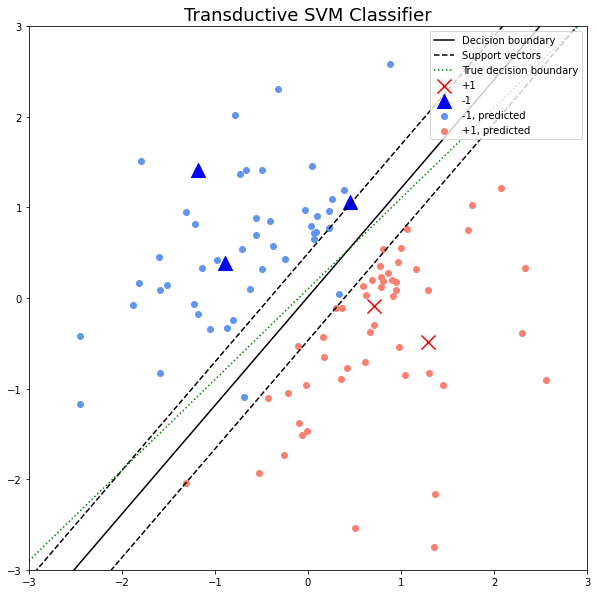

In [116]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.title("Transductive SVM Classifier", fontsize = 18)
for t, point in enumerate(x_train):
    if y_train[t] == 1: 
        plt.scatter(point[0],point[1], color = "r", marker = "x", s=200, label = "+1" if y_train.index(1) == t else "")
    elif y_train[t] == -1:
        plt.scatter(point[0],point[1], color = "b", marker = "^", s=200, label = "-1" if y_train.index(-1) == t else "")
for t, point in enumerate(x_test):
    if y_pred[t] == 1:
        plt.scatter(point[0],point[1], color = "salmon", marker = "o", label = "+1, predicted" if y_pred.index(1) == t else "")
    if y_pred[t] == -1:
        plt.scatter(point[0],point[1], color = "cornflowerblue", marker = "o", label = "-1, predicted" if y_pred.index(-1) == t else "")
        
theta_hat = list(clf.coef_[0])
theta0_hat = clf.intercept_[0]
x1s = [i/100 for i in range(-300,300)]
y1s = [-(x1*theta_hat[0]+theta0_hat)/theta_hat[1] for x1 in x1s]
y2s = [(1-x1*theta_hat[0]-theta0_hat)/theta_hat[1] for x1 in x1s]
y3s = [(-1-x1*theta_hat[0]-theta0_hat)/theta_hat[1] for x1 in x1s]
y0s = [(-x1*theta[0]-theta0)/theta[1] for x1 in x1s]

plt.plot(x1s, y1s, linestyle='-', color = 'k', label = "Decision boundary")
plt.plot(x1s, y2s, linestyle='--', color = 'k', label = "Support vectors")
plt.plot(x1s, y3s, linestyle='--', color = 'k')
plt.plot(x1s, y0s, linestyle='dotted', color = 'g', label = "True decision boundary")

#plt.quiver(0, 0, 1, 1)
ax.legend(loc = "upper right")

In [108]:
accuracy_score(y_test, y_pred)

0.9789473684210527

## Issues
- For TSVM it achieves an even split because we implicitly convey information through num_pos

## References

- https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights
- https://stackoverflow.com/questions/31161075/svm-in-matlab-meaning-of-parameter-box-constraint-in-function-fitcsvm#:~:text=A%20parameter%20that%20controls%20the,lead%20to%20longer%20training%20times.
- https://stackoverflow.com/questions/68819288/meaning-of-penalty-and-loss-in-linearsvc